## San Francisco Crime (Local Score: 2.10775820261   ,Kaggle Score: 2.43966)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['Dates'])
print(train_df.shape)

(878049, 9)


In [4]:
#train_df = train_df.sample(frac=0.5, random_state=1)

In [5]:
all_classes = ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS']

In [6]:
print('Any missing values?')
print('In train: ', pd.isnull(train_df).values.any())

Any missing values?
('In train: ', False)


#### Apriori probability of a certain crime to occure under certain address. Implemented as logarithmic odds ratio.

In [7]:
def odds(x):
    if x == 1.0:
        return 1.0
    else:
        return np.log(x)-np.log(1-x)
def update_odds(x):
    default = default_logodds.copy()
    val = oddUpdate[x]
    if len(val)!=1:
        default[val.keys()] = val
    return pd.Series(default)
    #return default

In [8]:
addresses = sorted(train_df["Address"].unique())
categories = sorted(train_df["Category"].unique())
logodds = {}

C_counts = train_df.groupby(["Category"]).size()
logoddsPA = dict((train_df.groupby('Address').size()/len(train_df)).apply(odds))
default_logodds = np.log(C_counts/len(train_df))-np.log(1.0-C_counts/float(len(train_df)))
oddUpdate = pd.Series(((train_df.groupby(['Address','Category']).size()/train_df.groupby(['Address']).size()).apply(odds)))
logodds = {k:update_odds(k) for k in addresses}

def compute_loggods(df, logodds, logoddsPA):
    
    address_features=df["Address"].apply(lambda x: logodds[x])
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    df["logoddsPA"]=df["Address"].apply(lambda x: logoddsPA[x])
    
    df = pd.concat([df,address_features], axis=1)
    
    return df


#### Date Features, Season Features, Working day in USA Feature, Night Feature

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import Holiday, HolidayCalendarFactory, FR, DateOffset

def transform_date(df):
    """
    Split Dates into Date, Year, Month, Day, DayofYear, Hour and Minute
    """
    df['Date'] = pd.to_datetime(df['Dates'].dt.date)
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['DayOfYear'] = df['Dates'].dt.dayofyear   # the ordinal day of the year
    df['Time'] = df['Dates'].dt.hour + df['Dates'].dt.minute/60
    df['Hour'] = df['Dates'].dt.hour
    df['Minutes'] = df['Dates'].dt.minute
    del df['Dates']
    
    return df

def dummy_day_of_week(df):
    listOfDays = df['DayOfWeek'].unique()
    
    for day in listOfDays:
        col_name = "is" + day
        
        df[col_name] = ((df['DayOfWeek'] == day) == True)
        
    return df

def compute_season(df):

    df['isSummer'] = ((df['Month'].isin([5,6,7])) == True)
    df['isFall']= ((df['Month'].isin([8,9,10])) == True)
    df['isWinter']= ((df['Month'].isin([11,0,1])) == True)
    df['isSpring']= ((df['Month'].isin([2,3,4])) == True)
    
    return df

def compute_working_days(df):
    """
    Check if working day, include information about holidays:
    New Year, Memorial Day, Independence Day, Labor Day, Thanksgiving, Black Friday, Christmas
    """
    cal = calendar()

    # create new rule for Black Friday
    USBlackFriday = Holiday('BlackFriday', month=11, day=1,
                            offset=DateOffset(weekday=FR(4)))

    # create own holiday calendar based on the above rules
    ownCal = HolidayCalendarFactory('OwnCalendar', cal, USBlackFriday)
    cal = ownCal()
    holidays = cal.holidays(start='2003-01-01', end='2015-05-13')

    # set flag according to whether the day is a holiday, a weekend or not
    df['isWorkingday'] = ((df['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) & 
                          (df['Date'].isin(holidays)==False))

    # transform from True/False into 1/0
    df['isWorkingday'] = df['isWorkingday'].astype(int)
    
    return df
    
def compute_night(df):
    df['Night'] = True
    
    df.loc[(df['Month'] ==  1) & (df['Time'] > 7.3) & (df['Time'] < 17.3), 'Night'] = False
    df.loc[(df['Month'] ==  2) & (df['Time'] > 7.0) & (df['Time'] < 17.8), 'Night'] = False
    df.loc[(df['Month'] ==  3) & (df['Time'] > 6.3) & (df['Time'] < 18.3), 'Night'] = False
    df.loc[(df['Month'] ==  4) & (df['Time'] > 5.5) & (df['Time'] < 18.8), 'Night'] = False
    df.loc[(df['Month'] ==  5) & (df['Time'] > 5.0) & (df['Time'] < 19.3), 'Night'] = False
    df.loc[(df['Month'] ==  6) & (df['Time'] > 4.8) & (df['Time'] < 19.5), 'Night'] = False
    df.loc[(df['Month'] ==  7) & (df['Time'] > 5.0) & (df['Time'] < 19.5), 'Night'] = False
    df.loc[(df['Month'] ==  8) & (df['Time'] > 5.5) & (df['Time'] < 19.0), 'Night'] = False
    df.loc[(df['Month'] ==  9) & (df['Time'] > 5.8) & (df['Time'] < 18.3), 'Night'] = False
    df.loc[(df['Month'] == 10) & (df['Time'] > 6.3) & (df['Time'] < 17.5), 'Night'] = False
    df.loc[(df['Month'] == 11) & (df['Time'] > 6.8) & (df['Time'] < 17.0), 'Night'] = False
    df.loc[(df['Month'] == 12) & (df['Time'] > 7.3) & (df['Time'] < 16.9), 'Night'] = False

    # transform from True/False into 1/0
    df['Night'] = df['Night'].astype(int)
    return df

def features_date(df):
    df = transform_date(df)
    df = compute_working_days(df)
    df = compute_season(df)
    df = compute_night(df)
    #df = dummy_day_of_week(df)
    
    return df

#### Intersection or Block, Dummy Encoding of Districts

In [10]:
def check_intersection(df):
    # check whether address is an intersection or not
    # one column, i.e. 1 for intersection and 0 for block should suffice
    df['isStreetCorner'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)
    return df

def dummy_districts(df):
    listOfDistricts = df['PdDistrict'].unique()
    
    for district in listOfDistricts:
        col_name = "is" + district
        
        df[col_name] = ((df['PdDistrict'] == district) == True)
        
    return df

def features_crime(df):
    df = compute_loggods(df, logodds, logoddsPA)
    df = check_intersection(df)
    #df = dummy_districts(df)
    
    return df

#### Clean Addresses names

In [11]:
def combine(str1, str2):
    # combine str1 and str2 ordered alphabetically
    return sorted([str1, str2], key=str.lower)[0] + ' ' + sorted([str1, str2], key=str.lower)[1]

def cleanIntersectionAddress(intAddress):
    intAddress['Street_1'] = intAddress['Address'].str.split('/').str[0].str.rstrip()
    intAddress['Street_2'] = intAddress['Address'].str.split('/').str[1].str.lstrip()
    # replace VIA * by *
    intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 'Street_1'].str.replace('VIA', '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 'Street_2'].str.replace('VIA', '').str.lstrip()
    # replace AVENUE OF THE PALMS by PALMS
    intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'), 'Street_1'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 'Street_2'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        intAddress.loc[intAddress['Street_1'].str.endswith(key), 'Street_1'] = \
            intAddress.loc[intAddress['Street_1'].str.endswith(key), 'Street_1'].str.replace(key, '').str.rstrip()
        intAddress.loc[intAddress['Street_2'].str.endswith(key), 'Street_2'] = \
            intAddress.loc[intAddress['Street_2'].str.endswith(key), 'Street_2'].str.replace(key, '').str.rstrip()

    # remove all whitespaces
    intAddress['Street_1'] = intAddress['Street_1'].str.replace(' ', '')
    intAddress['Street_2'] = intAddress['Street_2'].str.replace(' ', '')

    # create new address for the replacement, combine the names
    # in Street_1 and Street_2 in alphabetical ordering
    intAddress['Address'] = intAddress.apply(lambda x: combine(x['Street_1'], x['Street_2']), axis=1)
    return intAddress['Address']

def cleanBlockAddress(blockAddress):
    # remove 'Block' and 'of' from address
    mapping = [('Block', ''),
               ('of', '')
               ]
    for key, value in mapping:
        blockAddress['Address'] = blockAddress['Address'].str.replace(key, value)

    # get number from address
    blockAddress['Number'] = blockAddress['Address'].str.split().str[0]
    # get street name from address, remove leading whitespaces
    blockAddress['Street'] = blockAddress['Address'].str.split(' ', 1).str[1].str.lstrip()
    del blockAddress['Address']
    # replace VIA * by *
    blockAddress.loc[blockAddress['Street'].str.startswith('VIA'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('VIA'), 'Street'].str.replace('VIA', '').str.lstrip()
    # replace AVENUE OF THE PALMS by PALMS
    blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 'Street'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        blockAddress.loc[blockAddress['Street'].str.endswith(key), 'Street'] = \
            blockAddress.loc[blockAddress['Street'].str.endswith(key), 'Street'].str.replace(key, '').str.rstrip()

    # remove all whitespaces
    blockAddress['Street'] = blockAddress['Street'].str.replace(' ', '')
    # create new address for the replacement
    blockAddress['Address'] = blockAddress['Number'] + ' ' + blockAddress['Street']
    return blockAddress['Address']


def clean_intersect_block_address(df):
    df.loc[df['isStreetCorner'] == 0, 'Address'] = \
        cleanBlockAddress(pd.DataFrame(df.loc[df['isStreetCorner'] == 0, 'Address']))
    df.loc[df['isStreetCorner'] == 1, 'Address'] = \
        cleanIntersectionAddress(pd.DataFrame(df.loc[df['isStreetCorner'] == 1, 'Address']))
        
    return df


#### Clean outliers in coordinates, Scale(0:1), Rotated versions, Distance from centre of the map, Distance from crime heatpoint, 5x5 Grid

In [12]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def xy_clean(df):
    # medians of X and Y by police district
    listOfPrecincts = df['PdDistrict'].unique()
    precinctX = (df.groupby('PdDistrict'))['X'].median()
    precinctY = (df.groupby('PdDistrict'))['Y'].median()

    # impute wrong values with the medians
    for i in range(len(listOfPrecincts)) :
        df.loc[ (df['Y'] > 38) & (df['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
            precinctX[listOfPrecincts[i]]
        df.loc[(df['Y'] > 38) & (df['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
            precinctY[listOfPrecincts[i]]
            
    return df
        

def xy_scale(df):
    xy_scaler = MinMaxScaler() 
    xy_scaler.fit(df[["X","Y"]]) 
    df[["X","Y"]]=xy_scaler.transform(df[["X","Y"]]) 
    
    return df

def xy_rotate(df):
    """
    rotate coordinates by 30, 45, 60 degrees
    """
    df["rot45_X"] = 0.707* df["Y"] + 0.707* df["X"]
    df["rot45_Y"] = 0.707* df["Y"] - 0.707* df["X"]
    df["rot30_X"] = 0.866* df["X"] + 0.5* df["Y"]
    df["rot30_Y"] = 0.866* df["Y"] - 0.5* df["X"]
    df["rot60_X"] = 0.5* df["X"] + 0.866* df["Y"]
    df["rot60_Y"] = 0.5* df["Y"] - 0.866* df["X"] 
    return df

def xy_distance_from_center(df):
    """
    Compute radial distance from center of map
    """
    df["radial_r"] = np.sqrt( np.power(df["Y"],2) + np.power(df["X"],2) )
    return df


def xy_distance_from_crime_median(df, df_test=None):
    # medians of X and Y by crime category
    listOfCrimes = df['Category'].unique()
    crimeX = (df.groupby('Category'))['X'].median()
    crimeY = (df.groupby('Category'))['Y'].median()
    
    
    if df_test == None: 
        # compute distance from from crime median
        for crime_name in listOfCrimes:
        #for i in range(len(listOfCrimes)):
            df[crime_name+"_r"] = np.sqrt( np.power(df["Y"]-crimeY[crime_name],2) + np.power(df["X"]-crimeX[crime_name],2) )

            # debug version
            #df[listOfCrimes[0]+"_r"] = numpy.sqrt( numpy.power(df["Y"]-crimeY[listOfCrimes[0]],2) + numpy.power(df["X"]-crimeX[listOfCrimes[0]],2) )
      
        return df
    
    else:
        # compute distance from from crime median
        for crime_name in listOfCrimes:
            df_test[crime_name+"_r"] = np.sqrt( np.power(df_test["Y"]-crimeY[crime_name],2) + np.power(df_test["X"]-crimeX[crime_name],2) )

        return df_test        
        


def create_grid_xy(df,x_axis=5,y_axis=5):
    step_x = 1.0/x_axis
    step_y = 1.0/y_axis
    
    for i in range(x_axis):
        for j in range(y_axis):
            bin_name = 'Bin'+str(i)+'_'+str(j)
            
            if i == x_axis-1 & j != y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <=(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] < (j+1)*step_y) == True))
                              
            elif i != x_axis-1 & j == y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] <= (j+1)*step_y) == True))                
            elif i == x_axis-1 & j == y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <=(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] <= (j+1)*step_y) == True))               
            else:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] < (j+1)*step_y) == True))               

    return df
    
    
def features_xy(df):
    df = xy_clean(df)
    df = xy_scale(df)
    df = xy_rotate(df)
    df = xy_distance_from_center(df)
    #df =xy_distance_from_crime_median(df)
    #df = create_grid_xy(df,x_axis=5,y_axis=5)
    return df

#### Label Encoder

In [13]:
def label_encode(df):
    """
    Label encode PdDistrict and DayOfWeek
    """
    lab_enc = LabelEncoder()
    df['PdDistrict'] = lab_enc.fit_transform(df.PdDistrict)
    df['DayOfWeek'] = lab_enc.fit_transform(df.DayOfWeek)
    #df['Bin'] = lab_enc.fit_transform(df.Bin)
    return df

In [14]:
train_df = features_date(train_df)
train_df = features_crime(train_df)
train_df = clean_intersect_block_address(train_df)
train_df = features_xy(train_df)

train_df = label_encode(train_df)



#### Remove not needed columns

In [15]:
train_df = train_df.drop('Resolution', 1)
train_df = train_df.drop('Descript', 1)
train_df = train_df.drop('Date', 1)
train_df = train_df.drop('Address', 1)
#train_df = train_df.drop('PdDistrict', 1)
#train_df = train_df.drop('DayOfWeek', 1)
#train_df = train_df.drop('Year', 1)

In [16]:
best_features = ['Time', 'DayOfYear', 'Minutes', 'Day', 'Year', 'DayOfWeek', 'logodds21', 'logodds16', 'logoddsPA', 'logodds36', 'logodds20', 'logodds1', 'logodds35', 'X', 'logodds32', 'RUNAWAY_r', 'logodds37', 'logodds4', 'logodds25', 'logodds7', 'logodds13', 'rot60_Y', 'Y', 'logodds19', 'rot45_Y', 'rot30_X', 'rot30_Y', 'logodds12', 'logodds27', 'logodds38', 'RECOVERED VEHICLE_r', 'TREA_r', 'rot60_X', 'logodds34', 'rot45_X', 'VEHICLE THEFT_r', 'radial_r', 'logodds30', 'logodds28', 'logodds8', 'FAMILY OFFENSES_r', 'DRUG/NARCOTIC_r', 'BURGLARY_r', 'logodds5', 'PORNOGRAPHY/OBSCENE MAT_r', 'isWorkingday', 'SEX OFFENSES NON FORCIBLE_r', 'Night', 'MISSING PERSON_r', 'Month', 'GAMBLING_r', 'logodds15', 'VANDALISM_r', 'logodds24', 'isSummer', 'ARSON_r', 'logodds17', 'logodds6', 'DRIVING UNDER THE INFLUENCE_r', 'SECONDARY CODES_r', 'TRESPASS_r', 'OTHER OFFENSES_r', 'isFall', 'LARCENY/THEFT_r', 'WEAPON LAWS_r', 'logodds23', 'isStreetCorner', 'isThursday', 'KIDNAPPING_r', 'logodds0', 'isMonday', 'isSunday', 'isTuesday', 'BRIBERY_r', 'isSaturday', 'isSpring', 'logodds9', 'PROSTITUTION_r', 'DISORDERLY CONDUCT_r', 'SUICIDE_r', 'logodds18', 'WARRANTS_r', 'BAD CHECKS_r', 'isWinter', 'FORGERY/COUNTERFEITING_r', 'LOITERING_r', 'FRAUD_r', 'EXTORTION_r', 'STOLEN PROPERTY_r', 'ROBBERY_r', 'logodds26', 'EMBEZZLEMENT_r', 'logodds11', 'NON-CRIMINAL_r', 'ASSAULT_r', 'logodds2', 'logodds31', 'SUSPICIOUS OCC_r', 'LIQUOR LAWS_r', 'DRUNKENNESS_r', 'logodds3', 'logodds10', 'SEX OFFENSES FORCIBLE_r', 'isNORTHERN', 'isINGLESIDE', 'logodds14', 'Bin2_3', 'logodds29', 'isSOUTHERN', 'isTENDERLOIN', 'isPARK', 'isCENTRAL', 'Bin3_1', 'Bin2_0', 'Bin3_3', 'Bin1_1', 'Bin2_2', 'Bin1_2', 'isBAYVIEW', 'isRICHMOND', 'Bin1_0', 'Bin4_1', 'Bin3_0', 'Bin2_1', 'Bin1_3', 'Bin0_2', 'isTARAVAL', 'logodds22', 'Bin3_2', 'Bin0_1', 'Bin2_4', 'Bin3_4', 'Bin4_3', 'isMISSION', 'Bin0_3', 'Bin4_2', 'Bin4_0']

In [17]:
y_name = 'Category'
X_names = [col for col in train_df.columns.values if col not in y_name] 

X = train_df[X_names]
y = train_df[y_name]


print(X.shape)
print(y.shape)

(878049, 65)
(878049,)


In [18]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/home/i40/dbprak12/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

def xgb_probs(X_train, y_train, X_test):

    xgb_model = XGBClassifier(n_estimators=20,
                              learning_rate=0.2,
                              max_depth=9,
                              min_child_weight=5,
                              gamma=0.4,
                              reg_alpha=0.05,
                              reg_lambda=2,
                              subsample=1.0,
                              colsample_bytree=1.0,
                              max_delta_step=1,
                              scale_pos_weight=1,
                              objective='multi:softprob',
                              nthread=8,
                              seed=0 )
    
    xgb_model.fit(X_train, y_train)

    y_probs = xgb_model.predict_proba(X_test)
    
    return (y_probs, xgb_model)


In [20]:
from sklearn.metrics import log_loss

y_probs, model = xgb_probs(X_train, y_train, X_test)
score = log_loss(y_test, y_probs, labels=all_classes)
print("Score: {}".format(score))

Score: 2.10775820261


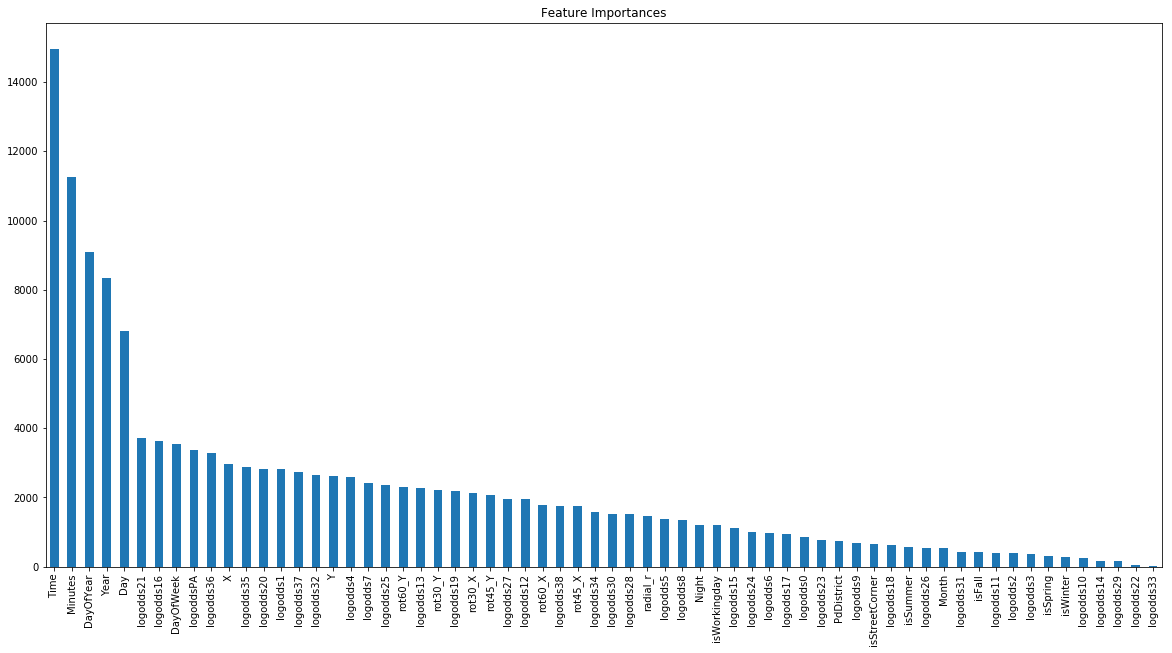

In [22]:
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(20,10))

feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()



In [ ]:
features = list(feat_imp.index)
print(features)

In [ ]:
from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 20,
                      learning_rate = 0.2,
                      max_depth = 9,
                      min_child_weight=5,
                      gamma = 0.4,
                      reg_alpha = 0.05,
                      reg_lambda = 2,
                      subsample = 1.0,
                      colsample_bytree = 1.0,
                      max_delta_step = 1,
                      scale_pos_weight = 1,
                      objective = 'multi:softprob',
                      nthread = 8,
                      seed = 0#,
                      #silent = False
)

#### Grid search of best parameters

In [ ]:
param_grid1 = {
               'max_depth':list(range(5,11,1)),
               'min_child_weight':list(range(3,7,1))
               'gamma':[0.4, 0.5]
               'subsample':[0.9, 1.0]
}

In [ ]:
from sklearn.cross_validation import KFold
kfold = KFold(len(y_train), n_folds=2,random_state=0)

In [ ]:
from sklearn.grid_search import GridSearchCV

print('run grid search...')
grid_search = GridSearchCV(xgb_model,
                                 cv =kfold, 
                                 param_grid = param_grid1,
                                 scoring = 'log_loss',
                                 n_jobs=6,
                                 verbose=10)
grid_search.fit(X_train, y_train)
print('Best parameters')
print(grid_search.best_params_)
print('Best score')
print(grid_search.best_score_)